In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import math

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics

from sklearn.metrics import make_scorer, precision_score, accuracy_score, recall_score, roc_auc_score, auc, average_precision_score, precision_recall_curve


SEED = 42
np.random.seed(SEED)
pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)

# Build models based on different feature sets and evaluate performance

In [2]:
df_all = pd.read_csv('Output/data_all.csv')
df_HE = pd.read_csv('Output/data_HE.csv')
features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
features = features.rename(columns = {'SC_score' : 'DeePhase_score'})
df_all_final = df_all.merge(features, left_on = 'Entry', right_on = 'Entry')
df_HE_final = df_HE.merge(features, left_on = 'Entry', right_on = 'Entry')
df_HE_final['condensate'] = np.where(df_HE_final['condensate'] == 'COND+', True, False)
df_HE_final['condensate'] = df_HE_final['condensate'].map({True: 1, False: 0})

In [3]:
cv = 10
test_frac = 0.2

In [4]:
df_model, test_df = train_test_split(df_HE_final, test_size=test_frac,
                                     stratify = df_HE_final['condensate'], random_state=42)

# First, let's evaluate predictive power based on just the homotypic phase separation propensity: 


In [5]:
#Train/val data
true_label = df_model['condensate']
prediction = df_model['DeePhase_score']
fpr, tpr, thresholds = metrics.roc_curve(true_label, prediction)
roc_auc_train = metrics.auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(true_label, prediction)
auc_precision_recall_train = auc(recall, precision)
print(str('auROC on train/val data: ' + str(np.mean(roc_auc_train))))
print(str('auPRC on train/val data: ' + str(np.mean(auc_precision_recall_train))))

#Performance on test data
aurocs = []; auprcs = []
for k in range(0, cv):
    test_df_here = test_df.sample(frac=0.9, random_state=k)
    true_label = test_df_here['condensate']
    prediction = test_df_here['DeePhase_score']
    fpr, tpr, thresholds = metrics.roc_curve(true_label, prediction)
    roc_auc_test = metrics.auc(fpr, tpr)
    aurocs.append(roc_auc_test)
    precision, recall, thresholds = precision_recall_curve(true_label, prediction)
    auc_precision_recall_test = auc(recall, precision)
    auprcs.append(auc_precision_recall_test)
print(str('auROC on test data: ' + str(np.mean(aurocs)) + '+/-' + str(np.std(aurocs))))
print(str('auPRC on test data: ' + str(np.mean(auprcs)) + '+/-' + str(np.std(auprcs))))

auROC on train/val data: 0.6431097802573594
auPRC on train/val data: 0.3498767043659704
auROC on test data: 0.6477432383122854+/-0.011240063679060336
auPRC on test data: 0.3707674557022761+/-0.014184710630096317


In [6]:
#No difference between train/val and test performance as no training was performed in this baseline scenario

# Next, train the model with hand-crafted features (EngF)

In [7]:
columns_phys = list(df_model.columns[30:98]) + ['condensate']
df_model_red = df_model[columns_phys]
df_test_red = test_df[columns_phys]

param_grid = {
    'n_estimators': [50, 100, 200],
    #'max_features': ['auto', 'sqrt'],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
}

X = df_model_red.drop('condensate', axis=1)
y = df_model_red['condensate']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier()
scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = scorer, cv = cv, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
#Performance on all of train & validation data with these hyperparameters:
X_train_val = df_model_red.drop('condensate', axis=1);
y_train_val = df_model_red['condensate']
y_pred_train_val = best_rf.predict_proba(X_train_val)[:, 1]
auroc_train_val = roc_auc_score(y_train_val, y_pred_train_val)
print(str('auROC on train/val data: ' + str(auroc_train_val)))
precision, recall, thresholds = precision_recall_curve(y_train_val, y_pred_train_val)
auprc_train_val = auc(recall, precision)
print(str('auPRC on train/val data: ' + str(auprc_train_val)))

#Performance on test data
aurocs = []; auprcs = []
for k in range(0, cv):
    test_df_here = df_test_red.sample(frac=0.9, random_state=k)
    X_test = test_df_here.drop('condensate', axis=1)
    y_test = test_df_here['condensate']
    
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_pred_proba)
    aurocs.append(test_auroc)

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    auc_precision_recall_test = auc(recall, precision)
    auprcs.append(auc_precision_recall_test)
print(str('auROC on test data: ' + str(np.mean(aurocs)) + '+/-' + str(np.std(aurocs))))
print(str('auPRC on test data: ' + str(np.mean(auprcs)) + '+/-' + str(np.std(auprcs))))

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best hyperparameters: {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 50}
auROC on train/val data: 0.917396219725203
auPRC on train/val data: 0.8347324861676879
auROC on test data: 0.8329439466975052+/-0.005406712277244273
auPRC on test data: 0.6557891388337888+/-0.012932702828447058


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/1614915720.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(features['prediction_phys'][features['Entry'].isin(pos_set)], label = 'positive set')
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/1614915720.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

Best Threshold=0.296000, G-Mean=0.841


(6143, 292)

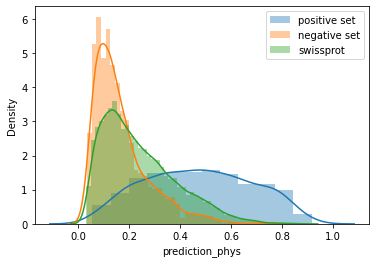

In [8]:
#Estimate scores across all the proteome:
model_phys = best_rf
columns_phys.remove('condensate')
predictions = np.array(model_phys.predict_proba(features[columns_phys])[:,1])
features['prediction_phys'] = predictions
pos_set = df_HE['Entry'][df_HE['condensate'] == 'COND+']
neg_set = df_HE['Entry'][df_HE['condensate'] == 'COND-']
sns.distplot(features['prediction_phys'][features['Entry'].isin(pos_set)], label = 'positive set')
sns.distplot(features['prediction_phys'][features['Entry'].isin(neg_set)], label = 'negative set')
sns.distplot(features['prediction_phys'][features['Entry'].isin(df_HE['Entry']) == False], label = 'swissprot')
plt.legend()

#Estimate Youden coefficient for optimal thresholding:
predictions_training_set = model_phys.predict_proba(df_model_red[columns_phys])[:,1]
fpr, tpr, thresholds = metrics.roc_curve(df_model_red['condensate'], predictions_training_set)
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
features[features['prediction_phys'] > thresholds[ix]].shape

# Now with hand-crafted features (EngF) + RNA-binding propensity

In [14]:
columns_RNA = list(df_HE_final.columns[30:98]) + ['RNA_binding', 'condensate']
df_model_red = df_model[columns_RNA]
df_test_red = test_df[columns_RNA]

param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2],
}


param_grid = {
    'n_estimators': [20, 50, 100, 200],
    #'max_features': ['auto', 'sqrt'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [1, 2, 4],
}



df_model, test_df = train_test_split(df_model_red, test_size = test_frac,
                                     stratify = df_model_red['condensate'], random_state=42)
X = df_model_red.drop('condensate', axis=1)
y = df_model_red['condensate']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier()
scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = scorer, cv = cv, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
#Performance on all of train & validation data with these hyperparameters:
X_train_val = df_model_red.drop('condensate', axis=1);
y_train_val = df_model_red['condensate']
y_pred_train_val = best_rf.predict_proba(X_train_val)[:, 1]
auroc_train_val = roc_auc_score(y_train_val, y_pred_train_val)
print(str('auROC on train/val data: ' + str(auroc_train_val)))
precision, recall, thresholds = precision_recall_curve(y_train_val, y_pred_train_val)
auprc_train_val = auc(recall, precision)
print(str('auPRC on train/val data: ' + str(auprc_train_val)))

    
#Performance on test data
aurocs = []; auprcs = []
for k in range(0, cv):
    test_df_here = df_test_red.sample(frac=0.9, random_state=k)
    X_test = test_df_here.drop('condensate', axis=1)
    y_test = test_df_here['condensate']
    
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_pred_proba)
    aurocs.append(test_auroc)

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    auc_precision_recall_test = auc(recall, precision)
    auprcs.append(auc_precision_recall_test)
print(str('auROC on test data: ' + str(np.mean(aurocs)) + '+/-' + str(np.std(aurocs))))
print(str('auPRC on test data: ' + str(np.mean(auprcs)) + '+/-' + str(np.std(auprcs))))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best hyperparameters: {'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 200}
auROC on train/val data: 0.9633191903482086
auPRC on train/val data: 0.9150523129589963
auROC on test data: 0.8005959661808413+/-0.003222740607316221
auPRC on test data: 0.6175859728893881+/-0.010022308092213586


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/2497343197.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(features['prediction_phys'][features['Entry'].isin(pos_set)], label = 'positive set')
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/2497343197.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

Best Threshold=0.292824, G-Mean=0.903


(5737, 294)

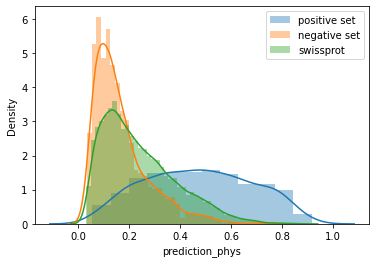

In [15]:
#Estimate scores across all the proteome:
model_RNA = best_rf
columns_RNA.remove('condensate')
predictions = np.array(model_RNA.predict_proba(features[columns_RNA])[:,1])
features['prediction_phys_and_RNA'] = predictions
pos_set = df_HE['Entry'][df_HE['condensate'] == 'COND+']
neg_set = df_HE['Entry'][df_HE['condensate'] == 'COND-']
sns.distplot(features['prediction_phys'][features['Entry'].isin(pos_set)], label = 'positive set')
sns.distplot(features['prediction_phys'][features['Entry'].isin(neg_set)], label = 'negative set')
sns.distplot(features['prediction_phys'][features['Entry'].isin(df_HE['Entry']) == False], label = 'swissprot')
plt.legend()

#Estimate Youden coefficient for optimal thresholding:
predictions_training_set = model_RNA.predict_proba(df_model_red[columns_RNA])[:,1]
fpr, tpr, thresholds = metrics.roc_curve(df_model_red['condensate'], predictions_training_set)
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
features[features['prediction_phys_and_RNA'] > thresholds[ix]].shape

# SeqVec based model

In [16]:
#Read in seqVec embeddings for the human proteome:
SV1 = pd.read_csv('Data/Features/SeqVec_13k.csv')
SV2 = pd.read_csv('Data/Features/SeqVec_7k.csv')
SeqVec = pd.concat([SV1, SV2], axis = 0)
cond_dict = dict(zip(df_HE_final['Entry'], df_HE_final['condensate']))
SeqVec['condensate'] = SeqVec['Entry'].map(cond_dict)
SeqVec_df = SeqVec[SeqVec.columns[3:]]
SeqVec_df = SeqVec_df.drop_duplicates(subset = 'Entry')
SeqVec_df = SeqVec_df.drop_duplicates(subset = 'Entry')
SeqVec_df = SeqVec_df[SeqVec_df['Entry'].isin(features['Entry'])]
df_SV_full = SeqVec_df[SeqVec_df['Entry'].isin(df_HE_final['Entry'])]
df_model, test_df = train_test_split(df_SV_full, test_size=test_frac,
                                     stratify = df_SV_full['condensate'], random_state=42)

In [17]:
columns_SV = list(df_model.columns[1:-2]) + ['condensate']
df_model_red = df_model[columns_SV]
df_test_red = test_df[columns_SV]


param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2],
}


param_grid = {
    'n_estimators': [100, 200],
    #'max_features': ['auto', 'sqrt'],
    'max_depth': [3, 6, 9, 12],
    'min_samples_leaf': [2, 4, 8],
}



X = df_model_red.drop('condensate', axis=1)
y = df_model_red['condensate']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier()
scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = scorer, cv = cv, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
#Performance on all of train & validation data with these hyperparameters:
X_train_val = df_model_red.drop('condensate', axis=1);
y_train_val = df_model_red['condensate']
y_pred_train_val = best_rf.predict_proba(X_train_val)[:, 1]
auroc_train_val = roc_auc_score(y_train_val, y_pred_train_val)
print(str('auROC on train/val data: ' + str(auroc_train_val)))
precision, recall, thresholds = precision_recall_curve(y_train_val, y_pred_train_val)
auprc_train_val = auc(recall, precision)
print(str('auPRC on train/val data: ' + str(auprc_train_val)))

    
#Performance on test data
aurocs = []; auprcs = []
for k in range(0, cv):
    test_df_here = df_test_red.sample(frac=0.9, random_state=k)
    X_test = test_df_here.drop('condensate', axis=1)
    y_test = test_df_here['condensate']
    
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_pred_proba)
    aurocs.append(test_auroc)

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    auc_precision_recall_test = auc(recall, precision)
    auprcs.append(auc_precision_recall_test)
print(str('auROC on test data: ' + str(np.mean(aurocs)) + '+/-' + str(np.std(aurocs))))
print(str('auPRC on test data: ' + str(np.mean(auprcs)) + '+/-' + str(np.std(auprcs))))

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best hyperparameters: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 100}
auROC on train/val data: 0.9806249049409399
auPRC on train/val data: 0.9588396783757794
auROC on test data: 0.7618966015851143+/-0.00602520579178174
auPRC on test data: 0.6015680849078963+/-0.008253779787409555


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/1170270350.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(features['prediction_SV'][features['Entry'].isin(pos_set)], label = 'positive set')
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/1170270350.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de441

Best Threshold=0.308287, G-Mean=0.937


(4372, 295)

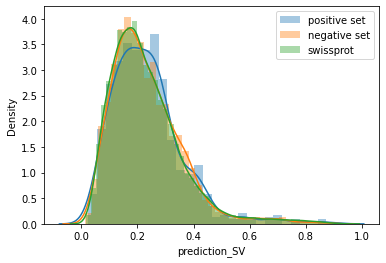

In [18]:
#Estimate scores across all the proteome:
model_SV = best_rf
columns_SV.remove('condensate')
predictions = np.array(model_SV.predict_proba(SeqVec_df[columns_SV])[:,1])
features['prediction_SV'] = predictions
pos_set = df_HE['Entry'][df_HE['condensate'] == 'COND+']
neg_set = df_HE['Entry'][df_HE['condensate'] == 'COND-']
sns.distplot(features['prediction_SV'][features['Entry'].isin(pos_set)], label = 'positive set')
sns.distplot(features['prediction_SV'][features['Entry'].isin(neg_set)], label = 'negative set')
sns.distplot(features['prediction_SV'][features['Entry'].isin(df_HE['Entry']) == False], label = 'swissprot')
plt.legend()

#Estimate Youden coefficient for optimal thresholding:
predictions_training_set = model_SV.predict_proba(df_model_red[columns_SV])[:,1]
fpr, tpr, thresholds = metrics.roc_curve(df_model_red['condensate'], predictions_training_set)
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
features[features['prediction_SV'] > thresholds[ix]].shape

# Combined model:

In [19]:
features['prediction_comb'] = 0.5*features['prediction_phys'] + 0.5 * features['prediction_SV']
pred_dict = dict(zip(features['Entry'], features['prediction_comb']))
df_HE_final['prediction_comb']  = df_HE_final['Entry'].map(pred_dict)

df_model, test_df = train_test_split(df_HE_final, test_size=test_frac,
                                     stratify = df_HE_final['condensate'], random_state=42)

In [20]:
#Train/val data
true_label = df_model['condensate']
prediction = df_model['prediction_comb']
fpr, tpr, thresholds = metrics.roc_curve(true_label, prediction)
roc_auc_train = metrics.auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(true_label, prediction)
auc_precision_recall_train = auc(recall, precision)
print(str('auROC on train/val data: ' + str(np.mean(roc_auc_train))))
print(str('auPRC on train/val data: ' + str(np.mean(auc_precision_recall_train))))

#Performance on test data
aurocs = []; auprcs = []
for k in range(0, cv):
    test_df_here = test_df.sample(frac = 0.9, random_state=k)
    true_label = test_df_here['condensate']
    prediction = test_df_here['prediction_comb']
    fpr, tpr, thresholds = metrics.roc_curve(true_label, prediction)
    roc_auc_test = metrics.auc(fpr, tpr)
    aurocs.append(roc_auc_test)
    precision, recall, thresholds = precision_recall_curve(true_label, prediction)
    auc_precision_recall_test = auc(recall, precision)
    auprcs.append(auc_precision_recall_test)
print(str('auROC on train/val data: ' + str(np.mean(aurocs)) + '+/-' + str(np.std(aurocs))))
print(str('auPRC on train/val data: ' + str(np.mean(auprcs)) + '+/-' + str(np.std(auprcs))))

auROC on train/val data: 0.869611422781043
auPRC on train/val data: 0.7351033630841298
auROC on train/val data: 0.764498471777069+/-0.0051932680612451374
auPRC on train/val data: 0.5472061911414291+/-0.01329884524965502


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/2590360912.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(features['prediction_comb'][features['Entry'].isin(pos_set)], label = 'positive set')
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_84703/2590360912.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

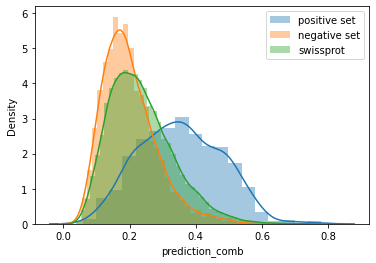

In [21]:
sns.distplot(features['prediction_comb'][features['Entry'].isin(pos_set)], label = 'positive set')
sns.distplot(features['prediction_comb'][features['Entry'].isin(neg_set)], label = 'negative set')
sns.distplot(features['prediction_comb'][features['Entry'].isin(df_HE_final['Entry']) == False], label = 'swissprot')
plt.legend()

In [22]:
features.to_csv('Output/predictions.csv')

# Compare model performances

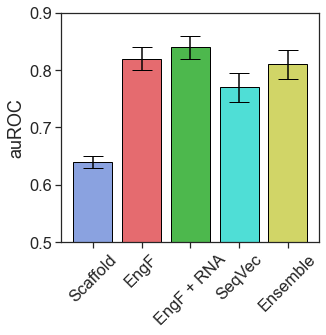

In [23]:
plt.figure(figsize=(5, 5))
sns.set_style("white")
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.5)

colors = ['#8aa2e0', '#e56b6f', '#4db84d', '#4fded6', '#d1d567']
labels = ['Scaffold', 'EngF', 'EngF + RNA', 'SeqVec', 'Ensemble']
values = [0.64, 0.82, 0.84, 0.77, 0.81]
errors = [0.01, 0.02, 0.02, 0.025, 0.025]  # Error bars of 0.01 for all cases

# Get colors from the tab10 colormap

# Create bar plot
plt.bar(labels, values, yerr=errors, capsize=10, color=colors, edgecolor='black')

# Title and labels
plt.ylabel('auROC')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.ylim([0.5, 0.9])

# Display the plot
plt.tight_layout()
plt.savefig('Plots/auROC_performance.pdf')
plt.show()

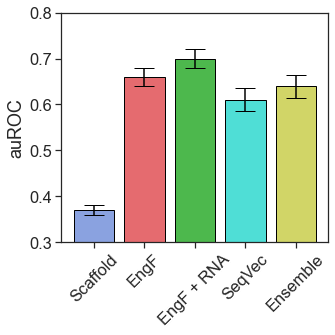

In [24]:
plt.figure(figsize=(5, 5))
sns.set_style("white")
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.5)

colors = ['#8aa2e0', '#e56b6f', '#4db84d', '#4fded6', '#d1d567']
labels = ['Scaffold', 'EngF', 'EngF + RNA', 'SeqVec', 'Ensemble']
values = [0.37, 0.66, 0.70, 0.61,  0.64]
errors = [0.01, 0.02, 0.02, 0.025, 0.025]  # Error bars of 0.01 for all cases

# Get colors from the tab10 colormap

# Create bar plot
plt.bar(labels, values, yerr=errors, capsize=10, color=colors, edgecolor='black')

# Title and labels
plt.ylabel('auROC')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.ylim([0.3, 0.8])

# Display the plot
plt.tight_layout()
plt.savefig('Plots/auPRC_performance.pdf')
plt.show()